## ALMA inference

The purpose of this project is to use ALMA model (write simple program to inference it through localhost web ui - no langchain, no complicated libraries, just simple webapp). 

This project could be also a way to test some solutions for web interfaces of more complicated DocWhisper project. 
Because model is not just translator, to get just translation functionality we got two options:
- hard prompting (ad hoc solution)
- disitlation of model (from decoder-only to encoder-decoder architecture)

1) we quantize model to smaller size (if X-ALMA will not be possible we could use GGUF version) - in other project we will learn how to quantize models to for example GGUF ourselves (patrz. BIBLIOTEKA_transformers-GPTs)
    - how to quatize model?
    - how to save it to for example GGUF?
2) we distill knowledge to smaller model
3) we create simple algo for inference
4) we import our custom model 

It is not worth to lower precision to int8 for pre-quantize model for now (I might look into it in a future)

In [ ]:
# Text to przetłumaczenia
# "Translate this from Polish to English:\nPolish: Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi. Jest to technika optymalizacji. Agentic Workflow z drugiej strony to wiele niezależnych modeli, które działają w ramach jakiejś aplikacji, np. jeśli dane wejściowe to obraz, działają agenci wizji komputerowej itp. Bagging trenuje kilka różnych modeli, każdy na innym zbiorze danych i uśrednia wyniki, a boosting używa kilku różnych modeli, z których każdy poprawia błędy poprzedniego. Czy to wyjaśnienie jest poprawne? \nEnglish:"

In [1]:
import torch
import pathlib
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
#from peft import PeftModel
#from transformers import pipeline
#from llama_cpp import Llama
import textract
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
cache_dir = pathlib.Path.cwd() / "Model"

GROUP2LANG = {
1: ["da", "nl", "de", "is", "no", "sv", "af"],
2: ["ca", "ro", "gl", "it", "pt", "es"],
3: ["bg", "mk", "sr", "uk", "ru"],
4: ["id", "ms", "th", "vi", "mg", "fr"],
5: ["hu", "el", "cs", "pl", "lt", "lv"],
6: ["ka", "zh", "ja", "ko", "fi", "et"],
7: ["gu", "hi", "mr", "ne", "ur"],
8: ["az", "kk", "ky", "tr", "uz", "ar", "he", "fa"],
}

LANG2GROUP = {lang: group for group, langs in GROUP2LANG.items() for lang in langs}
group_id = LANG2GROUP["pl"]

model_name = f"haoranxu/X-ALMA-13B-Group{group_id}"

In [5]:
!accelerate estimate-memory haoranxu/X-ALMA-13B-Group5 --library_name transformers

Loading pretrained config for `haoranxu/X-ALMA-13B-Group5` from `transformers`...
┌──────────────────────────────────────────────────────┐
│Memory Usage for loading `haoranxu/X-ALMA-13B-Group5` │
├───────┬─────────────┬──────────┬─────────────────────┤
│ dtype │Largest Layer│Total Size│ Training using Adam │
├───────┼─────────────┼──────────┼─────────────────────┤
│float32│   1.18 GB   │ 47.88 GB │      191.51 GB      │
│float16│  605.02 MB  │ 23.94 GB │       95.76 GB      │
│  int8 │  302.51 MB  │ 11.97 GB │         N/A         │
│  int4 │  151.25 MB  │ 5.98 GB  │         N/A         │
└───────┴─────────────┴──────────┴─────────────────────┘


In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [6]:
# loading model
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, cache_dir=cache_dir).to(device)  
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", cache_dir=cache_dir)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

### Check token size distribution for a single sentence

In [9]:
def calculate_token_histogram(tokenizer, text):
    """Calculate and display a histogram of token sizes per sentence."""
    if isinstance(text, bytes):
        text = text.decode("utf-8")  # Ensure text is a string

    sentences = text.split('. ')
    token_counts = defaultdict(int)

    for sentence in sentences:
        tokenized_length = len(tokenizer(sentence, return_tensors="pt").input_ids[0])
        token_counts[tokenized_length] += 1

    plt.figure(figsize=(8, 5))
    plt.bar(token_counts.keys(), token_counts.values(), color='skyblue')
    plt.xlabel('Token Count per Sentence')
    plt.ylabel('Frequency')
    plt.title('Sentence Token Count Histogram')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return dict(token_counts)

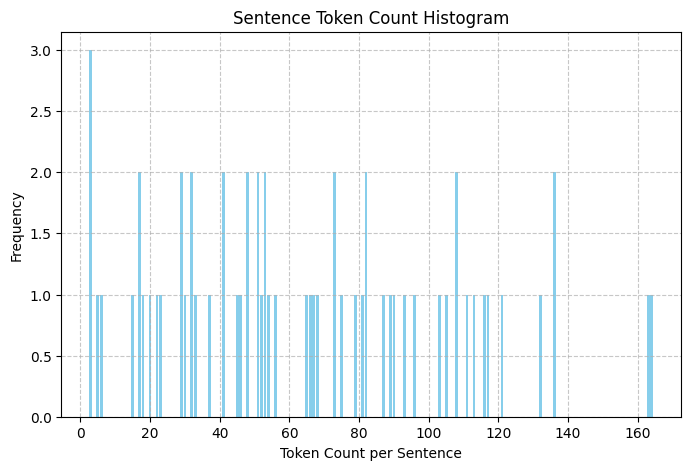

{45: 1,
 41: 2,
 6: 1,
 5: 1,
 29: 2,
 90: 1,
 22: 1,
 17: 2,
 3: 3,
 32: 2,
 136: 2,
 73: 2,
 46: 1,
 87: 1,
 53: 2,
 65: 1,
 48: 2,
 37: 1,
 52: 1,
 66: 1,
 93: 1,
 30: 1,
 108: 2,
 103: 1,
 15: 1,
 56: 1,
 23: 1,
 96: 1,
 163: 1,
 18: 1,
 20: 1,
 116: 1,
 51: 2,
 68: 1,
 81: 1,
 89: 1,
 54: 1,
 111: 1,
 117: 1,
 105: 1,
 79: 1,
 82: 2,
 75: 1,
 121: 1,
 67: 1,
 33: 1,
 132: 1,
 113: 1,
 164: 1}

In [15]:
text_test = textract.process("/home/kamil-solski/Documents/Python/Projekty_py/ALMA/Test_docs/Test_ALMA.docx").decode("utf-8")
calculate_token_histogram(tokenizer, text_test)  # lets just check how many tokens have sentences on average. It will be helpful to adjust max_tokens

### Inference of model

In [11]:
def split_text_into_chunks(tokenizer, text, max_tokens=250):
    """Split text into chunks without splitting sentences, ensuring each chunk fits max token size."""
    sentences = text.split('. ')
    chunks, current_chunk = [], ""
    for sentence in sentences:
        temp_chunk = current_chunk + sentence + ". "
        tokenized_length = len(tokenizer(temp_chunk, return_tensors="pt").input_ids[0])
        if tokenized_length <= max_tokens:
            current_chunk = temp_chunk
        else:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = sentence + ". "
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

In [16]:
text = "Translate this from Polish to English:\nPolish: Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi. Jest to technika optymalizacji. Agentic Workflow z drugiej strony to wiele niezależnych modeli, które działają w ramach jakiejś aplikacji, np. jeśli dane wejściowe to obraz, działają agenci wizji komputerowej itp. Bagging trenuje kilka różnych modeli, każdy na innym zbiorze danych i uśrednia wyniki, a boosting używa kilku różnych modeli, z których każdy poprawia błędy poprzedniego. Czy to wyjaśnienie jest poprawne? \nEnglish:"
chunks = split_text_into_chunks(tokenizer, text)

In [17]:
# Generate output with adjusted settings
output = []
for chunk in tqdm(chunks, desc="Generating progress"):
    chat_style_prompt = [{"role": "user", "content": chunk}]
    prompt = tokenizer.apply_chat_template(chat_style_prompt, tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            num_beams=3,           # Lowered beams for faster inference. TODO: check 5
            max_new_tokens=2048,   # Extended output length to 2048 tokens wich is maximum possible
            do_sample=True,
            temperature=0.6,       # Slightly higher temperature for more creative results. TODO: try lower (would be better for translation)
            top_p=0.9             # Slightly wider nucleus sampling for diversity. TODO: check other values
        )
        output.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

print("Generated Output:", " ".join(output))

Generating progress: 100%|██████████| 1/1 [00:29<00:00, 29.42s/it]

Generated Output: [INST] Translate this from Polish to English:
Polish: Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi. Jest to technika optymalizacji. Agentic Workflow z drugiej strony to wiele niezależnych modeli, które działają w ramach jakiejś aplikacji, np. jeśli dane wejściowe to obraz, działają agenci wizji komputerowej itp. Bagging trenuje kilka różnych modeli, każdy na innym zbiorze danych i uśrednia wyniki, a boosting używa kilku różnych modeli, z których każdy poprawia błędy poprzedniego. Czy to wyjaśnienie jest poprawne? 
English:. [/INST]So, MoE combines several other models to choose which trace (part of the model) should be used to get the correct answer. This is a technique of optimization. Agentic Workflow, on the other hand, is a set of several independent models that work within an application, e.g., if the input is an image, computer vision agents work, etc. Bagging trains severa

In [18]:
output

['[INST] Translate this from Polish to English:\nPolish: Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi. Jest to technika optymalizacji. Agentic Workflow z drugiej strony to wiele niezależnych modeli, które działają w ramach jakiejś aplikacji, np. jeśli dane wejściowe to obraz, działają agenci wizji komputerowej itp. Bagging trenuje kilka różnych modeli, każdy na innym zbiorze danych i uśrednia wyniki, a boosting używa kilku różnych modeli, z których każdy poprawia błędy poprzedniego. Czy to wyjaśnienie jest poprawne? \nEnglish:. [/INST]So, MoE combines several other models to choose which trace (part of the model) should be used to get the correct answer. This is a technique of optimization. Agentic Workflow, on the other hand, is a set of several independent models that work within an application, e.g., if the input is an image, computer vision agents work, etc. Bagging trains several different mo